In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
ds = pd.read_csv('Social_Network_Ads.csv')
X = ds.iloc[:, [2,3]].values
Y = ds.iloc[:, 4].values

In [6]:
from sklearn.cross_validation import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.25,random_state=0)

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [26]:
from sklearn.tree import DecisionTreeClassifier
classifier_DT = DecisionTreeClassifier(criterion='gini', random_state=0)
classifier_DT.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [27]:
from sklearn.ensemble import RandomForestClassifier
classifier_RF = RandomForestClassifier(n_estimators=10,criterion='entropy')
classifier_RF.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
from scipy import integrate
def capcurve(y_values, y_preds_proba):
    #Calculating the ideal curve datapoints for 'rate_pos_obs'
    # percent of users
    num_pos_obs = np.sum(y_values)
    num_count = len(y_values)
    rate_pos_obs = float(num_pos_obs) / float(num_count)
    ideal = pd.DataFrame({'x':[0,rate_pos_obs,1],'y':[0,1,1]})
    xx = np.arange(num_count) / float(num_count - 1)
    
    y_cap = np.c_[y_values,y_preds_proba]
    y_cap_df_s = pd.DataFrame(data=y_cap)
    y_cap_df_s = y_cap_df_s.sort_values([1], ascending=False)
    
    yy = np.cumsum(y_cap_df_s[0]) / float(num_pos_obs)
    yy = np.append([0], yy[0:num_count-1])
    
    percent = 0.5
    row_index = int(np.trunc(num_count * percent))

    val_y1 = yy[row_index]
    val_y2 = yy[row_index+1]
    if val_y1 == val_y2:
        val = val_y1*1.0
    else:
        val_x1 = xx[row_index]
        val_x2 = xx[row_index+1]
        val = val_y1 + ((val_x2 - percent)/(val_x2 - val_x1))*(val_y2 - val_y1)

    #Area under the ideal curve
    sigma_ideal = 1 * xx[num_pos_obs - 1 ] / 2 + (xx[num_count - 1] - xx[num_pos_obs]) * 1
    #Area under the selected model's curve
    sigma_model = integrate.simps(yy,xx)
    #Area under the random curve
    sigma_random = integrate.simps(xx,xx)

    #Accuracy ratio
    ar_value = (sigma_model - sigma_random) / (sigma_ideal - sigma_random)


    #Plotting the curves
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    
    ax.plot(ideal['x'],ideal['y'], color='grey', label='Ideal Model')
    
    ax.plot(xx,yy, color='red', label='Decision Tree Model')

    ax.plot(xx,xx, color='blue', label='Random Model')
    
    ax.plot([percent, percent], [0.0, val], color='green', linestyle='--', linewidth=1)
    ax.plot([0, percent], [val, val], color='green', linestyle='--',
            linewidth=1, label=str(val*100)+'% of positive obs at '+str(percent*100)+'%')

    plt.xlim(0, 1.02)
    plt.ylim(0, 1.25)
    plt.title("CAP Curve - accuracy ratio ="+str(ar_value))
    plt.xlabel('% of the users selected')
    plt.ylabel('% of users bought ads')
    plt.legend()
    plt.show()



In [30]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 12,10
Y_pred_proba = classifier_DT.predict_proba(X=X_test)
capcurve(y_values=Y_test, y_preds_proba=Y_pred_proba[:,1])

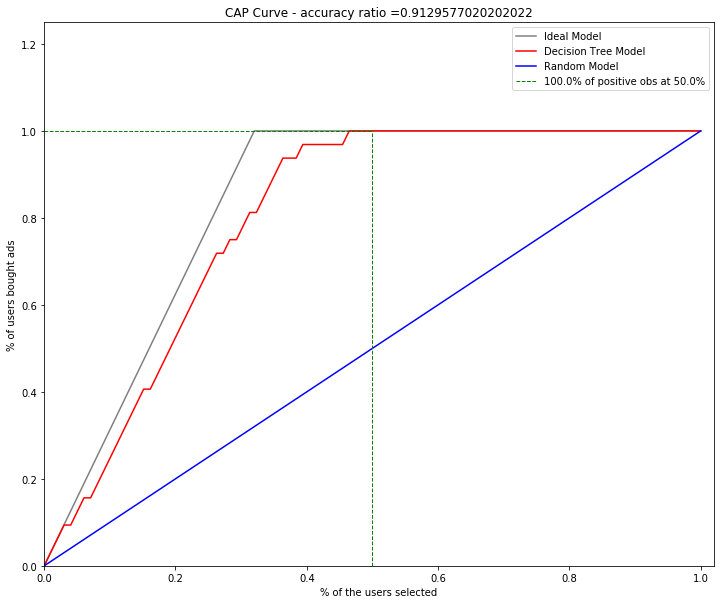

In [31]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 12,10
Y_pred_proba = classifier_RF.predict_proba(X=X_test)
capcurve(y_values=Y_test, y_preds_proba=Y_pred_proba[:,1])